In [56]:
import pandas as pd
import glob
import os
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [50]:
# generos = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'ScienceFiction', 'TVMovie', 'Thriller', 'War', 'Western']
# generos = ['Action', 'Adventure', 'Documentary', 'Romance', 'ScienceFiction', 'Thriller'] # SelectKBest
generos = ['Action', 'Adventure','Thriller','Documentary','Horror','Drama'] # RandomForestClassifier

def read_parquet(pasta):
    arquivos_parquet = glob.glob(os.path.join(pasta, '*.parquet'))
    lista_df = [pd.read_parquet(arquivo) for arquivo in arquivos_parquet]
    df = pd.concat(lista_df, ignore_index=True)
    return df

In [51]:
df_parquet = read_parquet('./preprocess/movies')[generos]
label = 'Action'
features = generos.copy()
features.remove(label)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(df_parquet[features], df_parquet[label], test_size=0.3, random_state=42, stratify=df_parquet[label])

In [53]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, make_scorer
# Definindo o número de folds
k = 10
skf = StratifiedKFold(n_splits=k)

# Definindo os valores de alpha para testar
param_grid = {'alpha': [1, 5, 10, 15, 20, 30, 50, 100]}
# param_grid = {'var_smoothing': [ 1e-100000, 1e-5000,1e-150, 1e-80, 1e-50, 1e-30, 1e-20, 1e-15, 1e-10, 1e-9, 1e-7]}

# Definindo a métrica de avaliação como precisão
scorer = make_scorer(precision_score, average='weighted')

# Inicializando o modelo CategoricalNB ou GaussianNB
model = CategoricalNB()

# Aplicando GridSearchCV com StratifiedKFold para encontrar o melhor hiperparâmetro
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=skf, scoring=scorer)

# Lista para armazenar as precisões
precisions = []
recalls = []
f1_scores = []
accuracies = []

# Iterando sobre os folds
for train_index, val_index in skf.split(X_train, y_train):
    # Separação entre treinamento e validação
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Balanceamento com Random Under Sampler (RUS)
    rus = RandomUnderSampler(random_state=42)
    X_train_fold, y_train_fold = rus.fit_resample(X_train_fold, y_train_fold)

    '''
    # Redução de dimensionalidade com PCA
    pca = PCA(n_components=10)
    X_train_fold = pca.fit_transform(X_train_fold)
    X_val_fold = pca.transform(X_val_fold)

    scaler_normalize = MinMaxScaler()
    X_train_fold = scaler_normalize.fit_transform(X_train_fold)
    X_val_fold = scaler_normalize.transform(X_val_fold)
    '''

    # Aplicando GridSearch para encontrar o melhor alpha
    grid_search.fit(X_train_fold, y_train_fold)
    
    # Melhor estimador encontrado pelo GridSearch
    best_model = grid_search.best_estimator_
    
    # Previsões no conjunto de validação com o melhor modelo
    y_pred = best_model.predict(X_val_fold)
    
    # Cálculo da precisão
    precision = precision_score(y_val_fold, y_pred, average='weighted')
    recall = recall_score(y_val_fold, y_pred, average='weighted')
    f1 = f1_score(y_val_fold, y_pred, average='weighted')
    accuracy = accuracy_score(y_val_fold, y_pred)

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    accuracies.append(accuracy)


# Média da precisão através dos folds
mean_precision = sum(precisions) / k
mean_recall = sum(recalls) / k
mean_f1 = sum(f1_scores) / k
mean_accuracy = sum(accuracies) / k

# Desvio padrão das métricas através dos folds
std_precision = np.std(precisions)
std_recall = np.std(recalls)
std_f1 = np.std(f1_scores)
std_accuracy = np.std(accuracies)

print(f'Média de Precisão: {mean_precision:.4f} ± {std_precision:.4f}')
print(f'Média de Revocação: {mean_recall:.4f} ± {std_recall:.4f}')
print(f'Média de F1-Score: {mean_f1:.4f} ± {std_f1:.4f}')
print(f'Média de Acurácia: {mean_accuracy:.4f} ± {std_accuracy:.4f}')
print(f'Melhor alpha encontrado: {grid_search.best_params_["alpha"]}')


Média de Precisão: 0.8231 ± 0.0059
Média de Revocação: 0.7760 ± 0.0061
Média de F1-Score: 0.7942 ± 0.0057
Média de Acurácia: 0.7760 ± 0.0061
Melhor alpha encontrado: 10


In [54]:
dataNB = {
    "Todas Features":{
        "mean_f1": 0.78,
        "std_f1": 0.0052,
        "mean_accuracy": 0.75,
        "std_accuracy": 0.0062,
        "mean_recall": 0.75,
        "std_recall": 0.0062,
        "mean_precision": 0.84,
        "std_precision": 0.0043
    },
    "PCA":{
        "mean_f1": 0.76,
        "std_f1": 0.0123,
        "mean_accuracy": 0.73,
        "std_accuracy": 0.0160,
        "mean_recall": 0.73,
        "std_recall": 0.0160,
        "mean_precision": 0.83,
        "std_precision": 0.0049
    },
    "SelectKBest":{
        "mean_f1": 0.78,
        "std_f1": 0.0046,
        "mean_accuracy": 0.75,
        "std_accuracy": 0.0053,
        "mean_recall": 0.75,
        "std_recall": 0.0053,
        "mean_precision": 0.82,
        "std_precision":0.0048
    },
    "RandomForestClassifier":{
        "mean_f1": 0.77,
        "std_f1": 0.0061,
        "mean_accuracy": 0.79,
        "std_accuracy": 0.0057,
        "mean_recall": 0.77,
        "std_recall": 0.0061,
        "mean_precision": 0.82,
        "std_precision":0.0059
    }
}

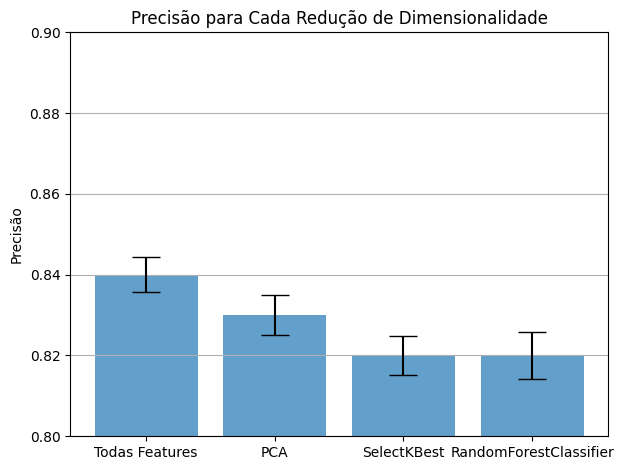

In [70]:
methods = list(dataNB.keys())
mean_f1 = [dataNB[method]["mean_precision"] for method in methods]
std_f1 = [dataNB[method]["std_precision"] for method in methods]

# Configuração do gráfico
x_pos = np.arange(len(methods))

fig, ax = plt.subplots()

# Criando o gráfico de barras
ax.bar(x_pos, mean_f1, yerr=std_f1, align='center', alpha=0.7, ecolor='black', capsize=10)
ax.set_ylabel('Precisão')
ax.set_xticks(x_pos)
ax.set_xticklabels(methods)
ax.set_title('Precisão para Cada Redução de Dimensionalidade')
ax.yaxis.grid(True)
ax.set_ylim([0.8, 0.9])

# Exibindo o gráfico
plt.tight_layout()
plt.show()
